In [1]:
from sqlalchemy import create_engine
from config import password
import pymysql
pymysql.install_as_MySQLdb()
import matplotlib.pyplot as plt
import pandas as pd

#Must install geopandas and dependencies first!!! conda install -c conda-forge geopandas
import geopandas as gp
from shapely.geometry import Point

In [2]:
#Connect to local database
rds_connection_string = f"root:{password}@localhost/medical_desert_db"
engine = create_engine(f'mysql://{rds_connection_string}')

In [3]:
#Join hpsa and uninsured by county
merger_table = pd.read_sql_query('SELECT h.county_name,h.longitude, h.latitude, u.total_population, u.total_uninsured_population FROM hpsa AS h JOIN uninsured AS u ON h.county_name = u.county_name', con=engine)

In [4]:
#preview df
merger_table.head()

,county_name,longitude,latitude,total_population,total_uninsured_population
0,Hillsborough County,-82.394713,27.705737,1339107,186640
1,Volusia County,-81.467121,29.240109,513218,72783
2,Miami-Dade County,-80.200343,25.778733,2676045,552802
3,Miami-Dade County,-80.231085,25.927185,2676045,552802
4,Duval County,-81.687190,30.386283,892880,114630


In [5]:
#load uninsured_rate table into dataframe
uninsured_rate_df = pd.read_sql_query('select * from uninsured_rate', con=engine)

In [6]:
#preview df
uninsured_rate_df.head()

,id,NAME,uninsured_rate
0,1,Hillsborough,13.937647
1,2,Volusia,14.181693
2,3,Miami-Dade,20.657425
3,4,Miami-Dade,20.657425
4,5,Duval,12.838231


In [7]:
#Remove duplicates and extra id
clean_uninsured_rate_df = uninsured_rate_df.drop(columns=['id']).drop_duplicates()

#Remove the space at the end of the county
#clean_uninsured_rate_df['NAME'] = clean_uninsured_rate_df['NAME'].str.strip()#not needed after adjusting table
clean_uninsured_rate_df.head()

,NAME,uninsured_rate
0,Hillsborough,13.937647
1,Volusia,14.181693
2,Miami-Dade,20.657425
4,Duval,12.838231
5,Collier,17.642699


In [8]:
#Load USA shape data into geopanda df
usa = gp.read_file("./tl_2017_us_state/tl_2017_us_state.shp")
county = gp.read_file("./cb_2015_us_county_500k/cb_2015_us_county_500k.shp")

#Get state(explore usa to get STATEFP for florida = 12)
state = usa[usa.STATEFP == '12']
#Get counties in state
fl = county[county.STATEFP=='12']
fl.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
33,12,009,00295749,0500000US12009,12009,Brevard,06,2629960540,1402786334,"POLYGON ((-80.98725 28.612997, -80.98468799999..."
34,12,039,00306918,0500000US12039,12039,Gadsden,06,1337193226,31687293,"POLYGON ((-84.93191899999999 30.606893, -84.92..."
35,12,055,00295756,0500000US12055,12055,Highlands,06,2632923680,231677932,"POLYGON ((-81.563704 27.35799, -81.563897 27.3..."
36,12,065,00295733,0500000US12065,12065,Jefferson,06,1549064068,99559047,"POLYGON ((-84.076161 30.124979, -84.075813 30...."
37,12,073,00306916,0500000US12073,12073,Leon,06,1727171503,90454011,"POLYGON ((-84.715144 30.333077, -84.713987 30...."


In [9]:
#Create point data for long and lat for med deserts and convert tp geodataframe
#Ref: https://gis.stackexchange.com/questions/174159/convert-a-pandas-dataframe-to-a-geodataframe
geometry = [Point(xy) for xy in zip(merger_table.longitude, merger_table.latitude)]
df = merger_table.drop(['longitude', 'latitude'], axis=1)
crs = {'init': 'epsg:4326'}#coordinate system?
gdf = gp.GeoDataFrame(df, crs=crs, geometry=geometry)
gdf.head()

,county_name,total_population,total_uninsured_population,geometry
0,Hillsborough County,1339107,186640,POINT (-82.39471279999999 27.70573745)
1,Volusia County,513218,72783,POINT (-81.46712149 29.24010866)
2,Miami-Dade County,2676045,552802,POINT (-80.20034327 25.7787325)
3,Miami-Dade County,2676045,552802,POINT (-80.23108452 25.92718547)
4,Duval County,892880,114630,POINT (-81.68718964999999 30.38628323)


In [10]:
#Merge uninsured rates by county
final_merge_df = pd.merge(fl,clean_uninsured_rate_df, on='NAME')

#check for null values
final_merge_df.loc[final_merge_df['uninsured_rate'].isnull()]#none

final_merge_df.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,uninsured_rate
0,12,009,00295749,0500000US12009,12009,Brevard,06,2629960540,1402786334,"POLYGON ((-80.98725 28.612997, -80.98468799999...",12.040045
1,12,055,00295756,0500000US12055,12055,Highlands,06,2632923680,231677932,"POLYGON ((-81.563704 27.35799, -81.563897 27.3...",14.231499
2,12,073,00306916,0500000US12073,12073,Leon,06,1727171503,90454011,"POLYGON ((-84.715144 30.333077, -84.713987 30....",9.124665
3,12,107,00306910,0500000US12107,12107,Putnam,06,1885199824,256515596,"POLYGON ((-82.056071 29.656846, -82.055027 29....",16.768365
4,12,117,00303665,0500000US12117,12117,Seminole,06,801546672,92810898,"POLYGON ((-81.459689 28.644357, -81.4595959999...",11.301523


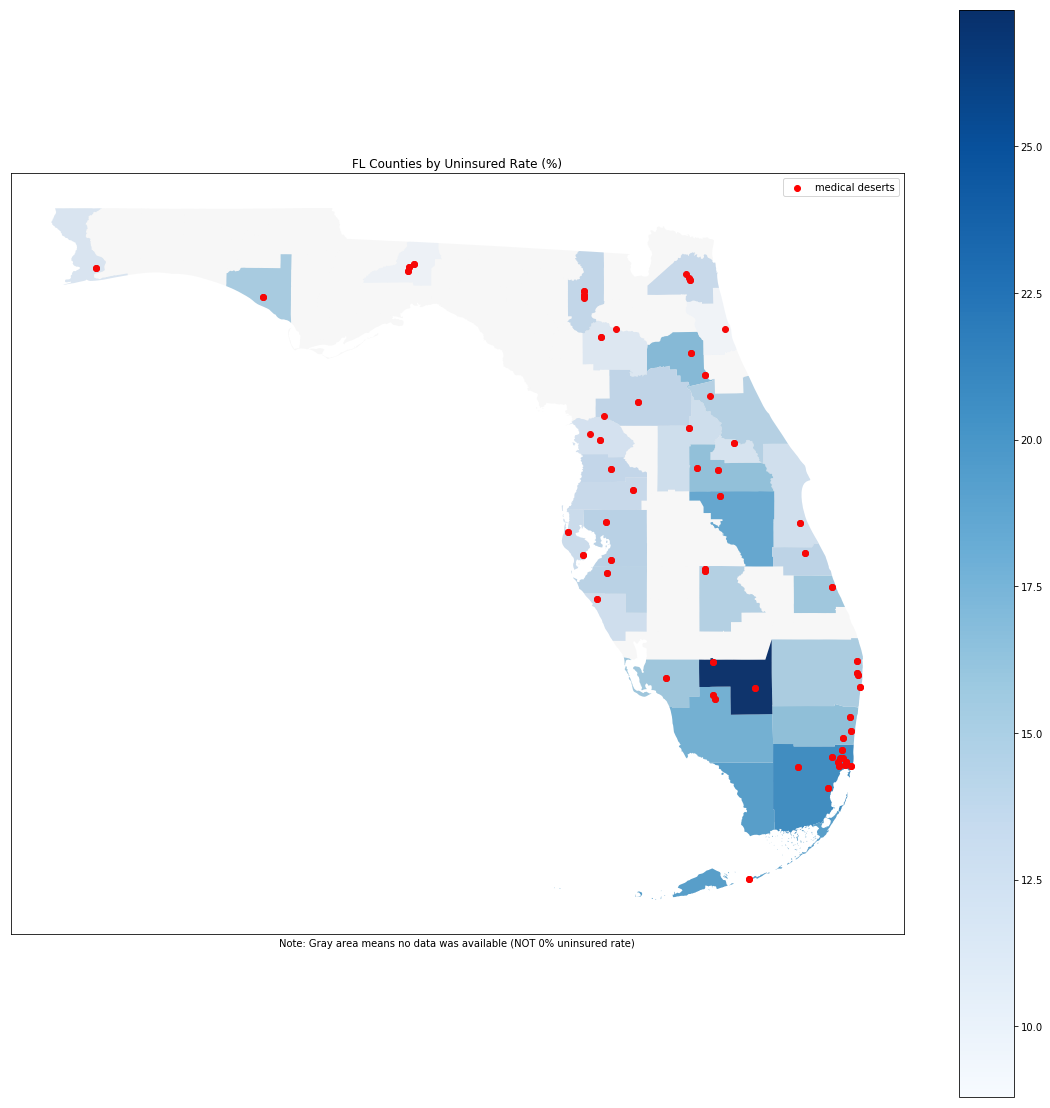

In [11]:
#Create choropleth, cmap controls color gradient
ax = final_merge_df.plot(figsize=(20,20), column='uninsured_rate', cmap="Blues",legend=True)

#removes axes
ax.set(xticks=[], yticks=[]) 

ax.set(xlabel = 'Note: Gray area means no data was available (NOT 0% uninsured rate)')
ax.set_title("FL Counties by Uninsured Rate (%)", fontsize='large')

#set medical desert location and uninsured rates
gdf.plot(ax=ax, color='red')

#Fill in the rest of the state and add legend
fl.plot(ax=ax,color='gray', alpha= 0.06)
plt.legend(labels=["medical deserts"])

#Save and show
plt.savefig("uninsured_rate_choropleth.png")
plt.show()